## Lab 1 - Analyzing Real Estate Data in St. Petersburg
We have data from Yandex.Realty classified https://realty.yandex.ru containing real estate listings for apartments in St. Petersburg and Leningrad Oblast from 2016 till the middle of August 2018. 

### Main objectives
After successful completion of the lab work students will be able to:
-	Analyze large datasets that don't work well in Excel using IPython notebook and pandas library
-   Find outliers and remove them in the datasets
-	Calculate different statistics on data fields

### Tasks
-	Calculate median and mean sell and rent prices in St. Petersburg (before and after cleaning without Leningrad Oblast)
Which of the statistics changed more and why?
-   Find outliers: too cheap or too expensive apartments which seem to be a wrong data. Remove them from the dataset.
-	Find houses with the most cheapest and most expensive prices per square meter.
-   Analyze how many rent offers have the commission and what is the most popular commission

In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly.express as px
import math
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [2]:
spb_df = pd.read_table('~/__DATA/E2ESML_Spring2023/data/spb.real.estate.archive.2018.tsv')
len(spb_df)

429187

In [3]:
spb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429187 entries, 0 to 429186
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   offer_id              429187 non-null  int64  
 1   first_day_exposition  429187 non-null  object 
 2   last_day_exposition   429187 non-null  object 
 3   last_price            429187 non-null  float64
 4   floor                 429187 non-null  int64  
 5   open_plan             429187 non-null  bool   
 6   rooms                 429187 non-null  int64  
 7   studio                429187 non-null  bool   
 8   area                  429187 non-null  float64
 9   kitchen_area          341591 non-null  float64
 10  living_area           364544 non-null  float64
 11  agent_fee             149229 non-null  float64
 12  renovation            295659 non-null  float64
 13  offer_type            429187 non-null  int64  
 14  category_type         429187 non-null  int64  
 15  

In [4]:
(spb_df.isna().sum() / len(spb_df)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')
#CHECK

,percent of NA
offer_id,0.00%
first_day_exposition,0.00%
last_day_exposition,0.00%
last_price,0.00%
floor,0.00%
open_plan,0.00%
rooms,0.00%
studio,0.00%
area,0.00%
kitchen_area,20.41%


#### Later will be hadled through a pipeline 

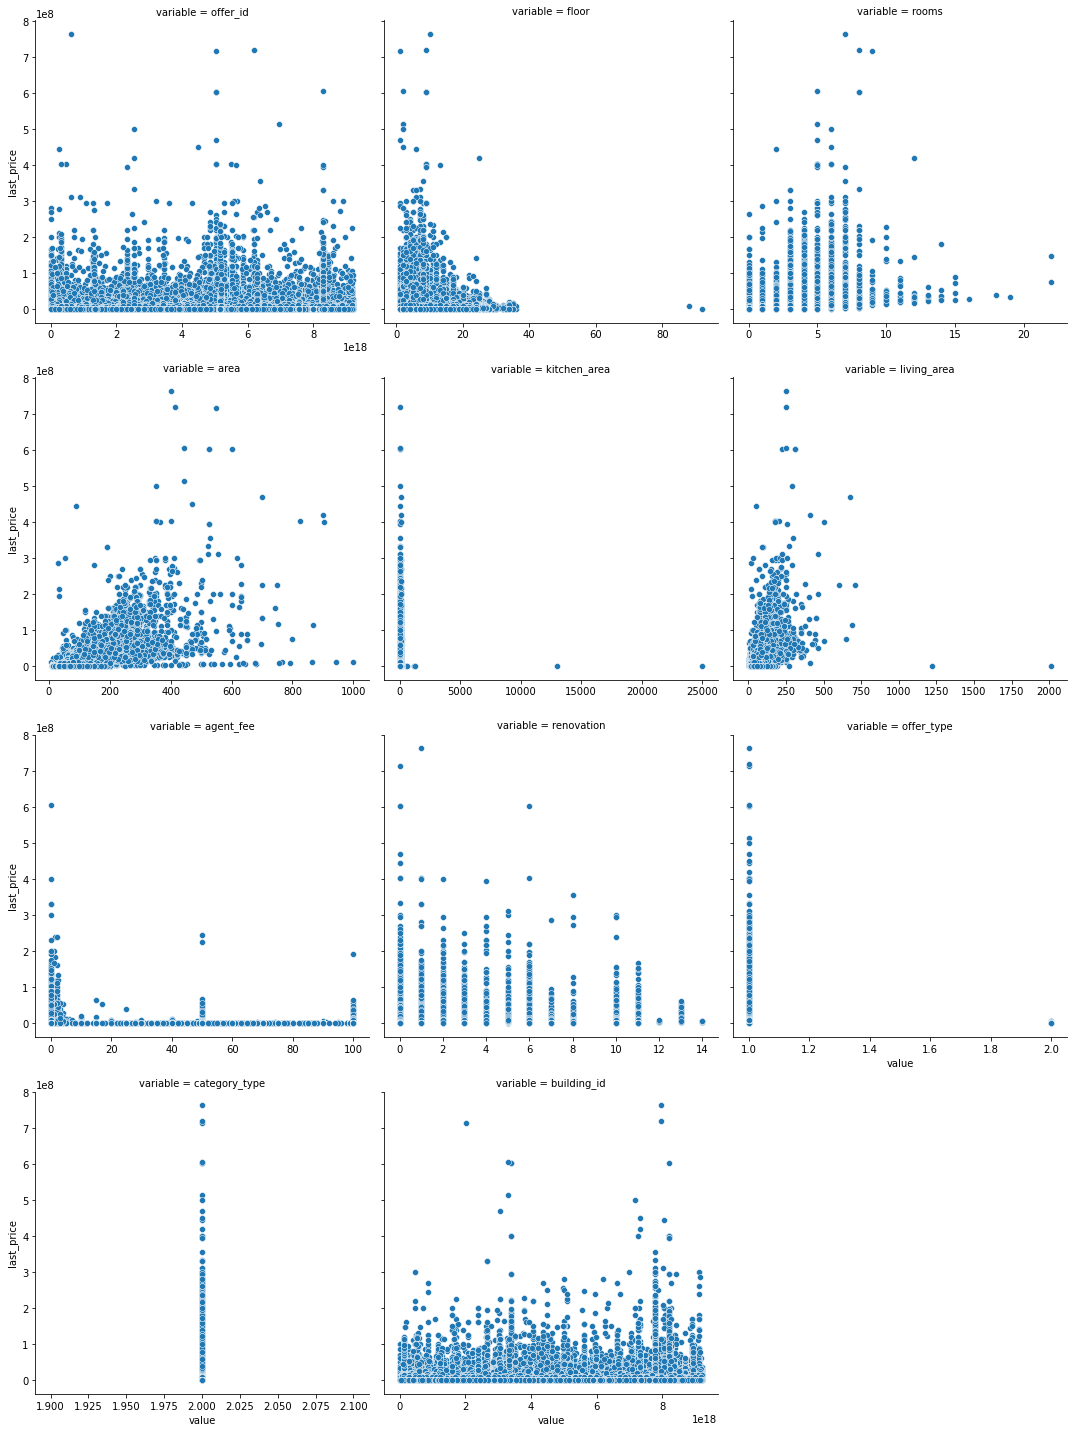

In [5]:
sns.relplot(data=spb_df.select_dtypes('number').melt(id_vars=['last_price']),
            x='value', y='last_price', col='variable', col_wrap=3, 
            facet_kws=dict(sharex=False)
           )

<AxesSubplot:xlabel='offer_type', ylabel='last_price'>

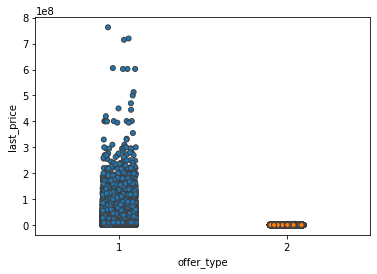

In [6]:
sns.stripplot(data=spb_df, x='offer_type', y='last_price', linewidth=1)

### Analyze prices for rent and sell
We see that we have both RENT and SELL data. 
<p>offer_type column contains data to distinct them, 2 stands for RENT, 1 for SELL


#### Analyze `rent prices` and `sell prices`

In [7]:
rent_df = spb_df[spb_df.offer_type == 2]
sell_df = spb_df[spb_df.offer_type == 1]

rent_df_spb = rent_df[rent_df.unified_address.str.contains('Россия, Санкт-Петербург')]
sell_df_spb = sell_df[sell_df.unified_address.str.contains('Россия, Санкт-Петербург')]
# .format function allows you to put variales' values instead of {} in the final string
print("Total rent data size: {}".format(len(rent_df)))
print("Total sell data size: {}".format(len(sell_df)))
print('---')
print("Rent data size in city limits: {}".format(len(rent_df_spb)))
print("Sell data size in city limits: {}".format(len(sell_df_spb)))

Total rent data size: 171186
Total sell data size: 258001
---
Rent data size in city limits: 156054
Sell data size in city limits: 197792


In [9]:
rent_df.shape

(171186, 17)

In [10]:
rent_df_spb.shape

(156054, 17)

##### We will work with the dataset without Len oblast next 

### BEFORE CLEANING

#### Find median and mean for apartments `in rent` and `for sale` before cleaning

In [11]:
def median(df):
    median = int(df.last_price.median())
    return median

def mean(df):
    mean = int(df.last_price.mean())
    return mean

rent_median_price = median(rent_df)
rent_mean_price = mean(rent_df)
print("Rent median price: {}".format(rent_median_price))
print("Rent mean price: {}".format(rent_mean_price))
sell_median_price = median(sell_df)
sell_mean_price = mean(sell_df)
print("Sell median price: {}".format(sell_median_price))
print("Sell mean price: {}".format(sell_mean_price))

print('---')

print("In city limits:")
rent_spb_median_price = median(rent_df_spb)
rent_spb_mean_price = mean(rent_df_spb)
print("Rent median price in city limits: {}".format(rent_spb_median_price))
print("Rent mean price in city limits: {}".format(rent_spb_mean_price))
sell_spb_median_price = median(sell_df_spb)
sell_spb_mean_price = mean(sell_df_spb)
print("Sell median price in city limits: {}".format(sell_spb_median_price))
print("Sell mean price in city limits: {}".format(sell_spb_mean_price))

Rent median price: 25000
Rent mean price: 31719
Sell median price: 4599000
Sell mean price: 6969288
---
In city limits:
Rent median price in city limits: 25000
Rent mean price in city limits: 33015
Sell median price in city limits: 5300000
Sell mean price in city limits: 8151204


Mean values changed more because median is more robust to outliers 

#### Let's look at the most expensive and cheapest apartments `in rent` and `for sale` without Leningrad Oblast

In [12]:
max_price_rent = int(rent_df_spb.last_price.max())
print("Max price in rent: {} per month".format(max_price_rent))
min_price_rent = int(rent_df_spb.last_price.min())
print("Min price in rent: {} per month".format(min_price_rent))

max_price_sell = int(sell_df_spb.last_price.max())
print("Max price for sale: {}".format(max_price_sell))
min_price_sell = int(sell_df_spb.last_price.min())
print("Min price for sale: {}".format(min_price_sell))

Max price in rent: 4900000 per month
Min price in rent: 130 per month
Max price for sale: 763000000
Min price for sale: 19000


#### Calculate price per square meter, get median and mean prices`for rent` and `for sale`

In [13]:
rent_df_spb['price_per_sq_m'] = rent_df_spb.last_price/rent_df_spb.area
sell_df_spb['price_per_sq_m'] = sell_df_spb.last_price/sell_df_spb.area

median_price_per_sq_m_rent = int(rent_df_spb.price_per_sq_m.median())
mean_price_per_sq_m_rent = int(rent_df_spb.price_per_sq_m.mean())
print("Median price per sq m in rent: {}".format(median_price_per_sq_m_rent))
print("Mean price per sq m in rent: {}".format(mean_price_per_sq_m_rent))

median_price_per_sq_m_sell = int(sell_df_spb.price_per_sq_m.median())
mean_price_per_sq_m_sell = int(sell_df_spb.price_per_sq_m.mean())
print("Median price per sq m for sale: {}".format(median_price_per_sq_m_sell))
print("Mean price per sq m for sale: {}".format(mean_price_per_sq_m_sell))

Median price per sq m in rent: 555
Mean price per sq m in rent: 610
Median price per sq m for sale: 102285
Mean price per sq m for sale: 113645


/tmp/ipykernel_499/4232408214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_spb['price_per_sq_m'] = rent_df_spb.last_price/rent_df_spb.area
/tmp/ipykernel_499/4232408214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_df_spb['price_per_sq_m'] = sell_df_spb.last_price/sell_df_spb.area


In [14]:
rent_df_spb.shape

(156054, 18)

In [15]:
sell_df_spb.shape

(197792, 18)

#### Find median price per sq m per house `for rent` and `for sale`

In [22]:
house_rent_df = rent_df_spb.groupby('unified_address').price_per_sq_m.median().reset_index()
house_sell_df = sell_df_spb.groupby('unified_address').price_per_sq_m.median().reset_index()

house_rent_df.rename(columns = {'price_per_sq_m': 'house_price_sqm_median'}, inplace = True)
house_sell_df.rename(columns = {'price_per_sq_m': 'house_price_sqm_median'}, inplace = True)

In [19]:
house_rent_df.shape

(19857, 2)

In [20]:
house_sell_df.shape

(22972, 2)

In [35]:
house_rent_df

,unified_address,house_price_sqm_median
0,"Россия, Санкт-Петербург, 1-й Муринский проспект, 11",571.383648
1,"Россия, Санкт-Петербург, 1-й Муринский проспект, 13",500.000000
2,"Россия, Санкт-Петербург, 1-й Муринский проспект, 15",569.743935
3,"Россия, Санкт-Петербург, 1-й Муринский проспект, 17",600.000000
4,"Россия, Санкт-Петербург, 1-й Муринский проспект, 19",482.142857
...,...,...
19852,"Россия, Санкт-Петербург, шоссе Революции, 50",511.111111
19853,"Россия, Санкт-Петербург, шоссе Революции, 84",485.714286
19854,"Россия, Санкт-Петербург, шоссе Революции, 84к1",628.571429
19855,"Россия, Санкт-Петербург, шоссе Революции, 8А",550.000000


In [36]:
house_sell_df

,unified_address,house_price_sqm_median
0,"Россия, Санкт-Петербург, 1-й Муринский проспект, 11",102630.689500
1,"Россия, Санкт-Петербург, 1-й Муринский проспект, 13",99834.656085
2,"Россия, Санкт-Петербург, 1-й Муринский проспект, 15",91615.179391
3,"Россия, Санкт-Петербург, 1-й Муринский проспект, 17",79189.163588
4,"Россия, Санкт-Петербург, 1-й Муринский проспект, 19",97281.369639
...,...,...
22967,"Россия, Санкт-Петербург, шоссе Революции, 51",67027.027027
22968,"Россия, Санкт-Петербург, шоссе Революции, 51Б",82894.736842
22969,"Россия, Санкт-Петербург, шоссе Революции, 84к1",84745.762712
22970,"Россия, Санкт-Петербург, шоссе Революции, 88Д",98639.455782


#### Merge rent data with house median prices and inspect outliers `for rent` and `for sale`

In [24]:
# As these 2 dataframes have only one common column name (unified_address) it will merge dataframes by it
rent_df_merged = rent_df_spb.merge(house_rent_df)
# Assign outliers if price per sq m is 5 times higher than the median value in the house
outliers_rent = rent_df_merged[(rent_df_merged.price_per_sq_m/rent_df_merged.house_price_sqm_median) > 5]

sell_df_merged = sell_df_spb.merge(house_sell_df)
outliers_sell = sell_df_merged[(sell_df_merged.price_per_sq_m/sell_df_merged.house_price_sqm_median) > 5]

print(f'N of MAX outliers in rent: {len(outliers_rent)}')
print(f'N of MAX outliers for sale: {len(outliers_sell)}')

N of MAX outliers in rent: 47
N of MAX outliers for sale: 39


In [25]:
rent_df_merged.shape

(156054, 19)

In [26]:
sell_df_merged.shape

(197792, 19)

#### Clean data from the MAX outliers `for rent` and `for sale`

<AxesSubplot:>

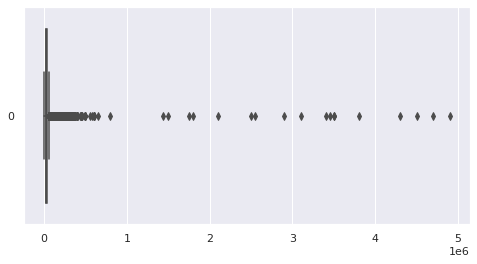

In [27]:
sns.set(rc = {'figure.figsize':(8, 4)})
sns.boxplot(data=rent_df_merged['last_price'],orient='h')

<AxesSubplot:>

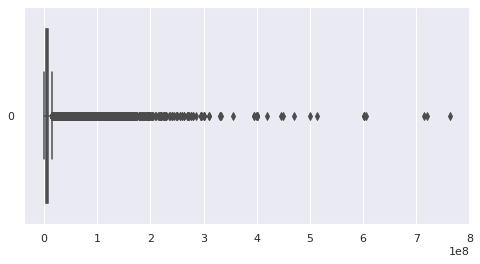

In [28]:
sns.set(rc = {'figure.figsize':(8, 4)})
sns.boxplot(data=sell_df_merged['last_price'],orient='h')

In [32]:
rent_df_cleaned = rent_df_merged[~((rent_df_merged.price_per_sq_m/rent_df_merged.house_price_sqm_median) > 5)]
rent_df_cleaned = rent_df_cleaned[rent_df_cleaned.last_price < 1000000]

sell_df_cleaned = sell_df_merged[~((sell_df_merged.price_per_sq_m/sell_df_merged.house_price_sqm_median) > 5)]
sell_df_cleaned = sell_df_cleaned[sell_df_cleaned.last_price < 400000000]

In [35]:
outliers_count_rent = len(rent_df_cleaned[(rent_df_cleaned.price_per_sq_m > 3000) 
                                     & ((rent_df_cleaned.house_price_sqm_median < 1000) 
                                        | (rent_df_cleaned.house_price_sqm_median == rent_df_cleaned.price_per_sq_m))])
print("Outliers found in rent: {}".format(outliers_count_rent))
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m > 3000) 
                                     & ((rent_df_cleaned.house_price_sqm_median < 1000) 
                                        | (rent_df_cleaned.house_price_sqm_median == rent_df_cleaned.price_per_sq_m)))]

outliers_count_sell = len(sell_df_cleaned[(sell_df_cleaned.price_per_sq_m > 460000) 
                                     & ((sell_df_cleaned.house_price_sqm_median < 170000) 
                                        | (sell_df_cleaned.house_price_sqm_median == sell_df_cleaned.price_per_sq_m))])
print("Outliers found in sale: {}".format(outliers_count_sell))
sell_df_cleaned = sell_df_cleaned[~((sell_df_cleaned.price_per_sq_m > 460000) 
                                     & ((sell_df_cleaned.house_price_sqm_median < 170000) 
                                        | (sell_df_cleaned.house_price_sqm_median == sell_df_cleaned.price_per_sq_m)))]

Outliers found in rent: 8
Outliers found in sale: 82


In [36]:
rent_df_merged.shape, sell_df_merged.shape

(156054, 19)

#### Outliers for rent

<AxesSubplot:>

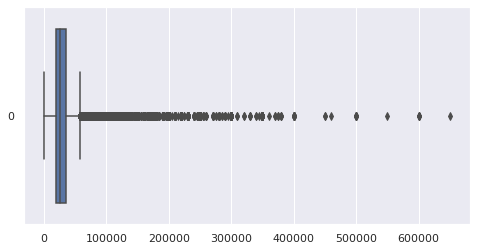

In [38]:
sns.set(rc = {'figure.figsize':(8, 4)})
sns.boxplot(data=rent_df_cleaned['last_price'], orient='h')

In [39]:
def out_iqr(df , column):
    global lower,upper
    q25, q85 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.85)
    # calculate the IQR
    iqr = q85 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 13
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q85 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    print('Total number of outliers (min) are', df2.shape[0])
    print('Total number of outliers (max) are', df1.shape[0])
    return print('Total number of outliers are', df1.shape[0] + df2.shape[0])

In [42]:
out_iqr(rent_df_cleaned,'last_price') 

The IQR is 25000.0
The lower bound value is -305000.0
The upper bound value is 370000.0
Total number of outliers (min) are 0
Total number of outliers (max) are 30
Total number of outliers are 30


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


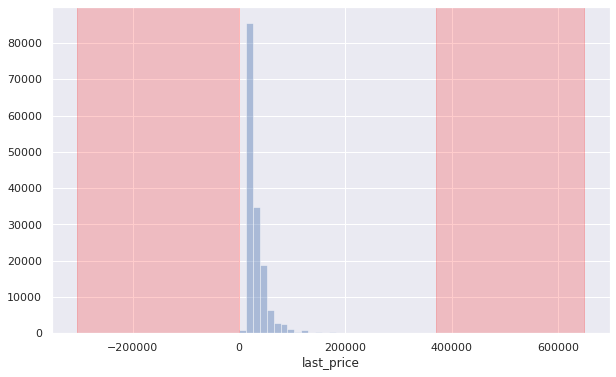

In [43]:
plt.figure(figsize = (10,6))
sns.distplot(rent_df_cleaned['last_price'], kde=False)
plt.axvspan(xmin = lower,xmax= rent_df_cleaned['last_price'].min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= rent_df_cleaned['last_price'].max(),alpha=0.2, color='red')

In [44]:
rent_df_cleaned = rent_df_cleaned[(rent_df_cleaned['last_price'] < upper)] #if there is no lower, drop it

In [45]:
rent_df_merged.shape, sell_df_merged.shape

((156054, 19), (197792, 19))

<AxesSubplot:>

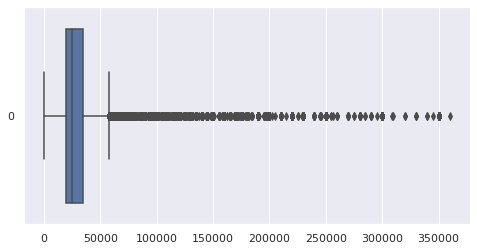

In [46]:
sns.set(rc = {'figure.figsize':(8, 4)})
sns.boxplot(data=rent_df_cleaned['last_price'], orient='h')

#### Outliers for sale

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='last_price'>

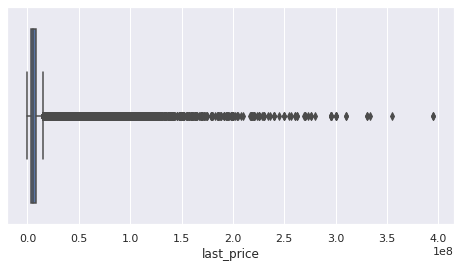

In [47]:
sns.set(rc = {'figure.figsize':(8, 4)})
sns.boxplot(sell_df_cleaned['last_price'], orient='h')

In [48]:
out_iqr(sell_df_cleaned,'last_price') 

The IQR is 7090000.0
The lower bound value is -88270000.0
The upper bound value is 103160000.0
Total number of outliers (min) are 0
Total number of outliers (max) are 512
Total number of outliers are 512


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


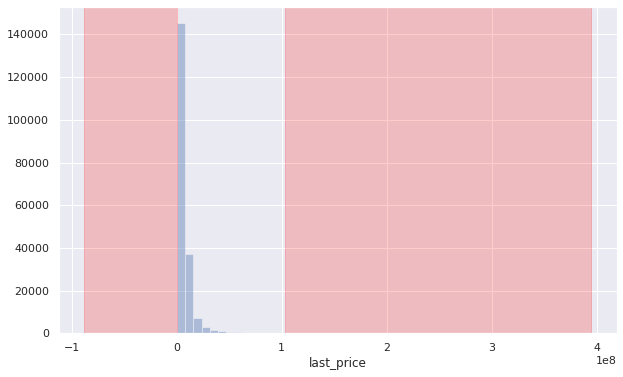

In [49]:
plt.figure(figsize = (10,6))
sns.distplot(sell_df_cleaned['last_price'], kde=False)
plt.axvspan(xmin = lower,xmax= sell_df_cleaned['last_price'].min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= sell_df_cleaned['last_price'].max(),alpha=0.2, color='red')

In [50]:
sell_df_cleaned = sell_df_cleaned[(sell_df_cleaned['last_price'] < upper)] #if there is no lower, drop it

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='last_price'>

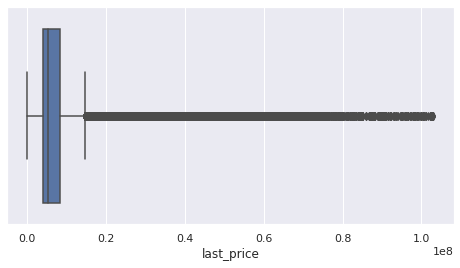

In [51]:
sns.set(rc = {'figure.figsize':(8, 4)})
sns.boxplot(sell_df_cleaned['last_price'], orient='h')

In [52]:
rent_df_merged.shape, sell_df_merged.shape

((156054, 19), (197792, 19))

#### Clean data from the MIN outliers `for rent` and `for sale`

In [53]:
median_price_per_sq_m_rent_cleaned = int(rent_df_cleaned.price_per_sq_m.median())
mean_price_per_sq_m_rent_cleaned = int(rent_df_cleaned.price_per_sq_m.mean())
print("Median price per sq m in St. Petersburg in rent: {}".format(median_price_per_sq_m_rent_cleaned))
print("Mean price per sq m in St. Petersburg in rent: {}".format(mean_price_per_sq_m_rent_cleaned))

Median price per sq m in St. Petersburg in rent: 555
Mean price per sq m in St. Petersburg in rent: 600


In [54]:
# it seems that we should clean all apartments where median price is at least 2x higher and cheap 
outliers = rent_df_cleaned[(rent_df_cleaned.price_per_sq_m < 250) 
                               & (rent_df_cleaned.house_price_sqm_median/rent_df_cleaned.price_per_sq_m >= 2)]
print("Number of cheap outliers 2x cheaper: {}".format(len(outliers)))

Number of cheap outliers 2x cheaper: 100


In [55]:
# clean outliers
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m < 250) 
                               & (rent_df_cleaned.house_price_sqm_median/rent_df_cleaned.price_per_sq_m >= 2))]

# there are cases where houses had just one offer and house median equals offer's price per square meter
# let's remove these outliers
rent_df_cleaned_spb = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m < 200) 
                                          & (rent_df_cleaned.price_per_sq_m == rent_df_cleaned.house_price_sqm_median))]
# look at the cheapest apartment
cheapest_offer = rent_df_cleaned[rent_df_cleaned.price_per_sq_m == rent_df_cleaned.price_per_sq_m.min()]
cheapest_offer

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,agent_fee,renovation,offer_type,category_type,unified_address,building_id,price_per_sq_m,house_price_sqm_median
100303,801981697508642560,2016-06-20T00:00:00+03:00,2016-06-29T00:00:00+03:00,12000.0,6,False,5,False,156.0,23.0,16.0,50.0,11.0,2,2,"Россия, Санкт-Петербург, Большая Зеленина улица, 12",7137635118733633172,76.923077,76.923077


In [56]:
rent_df_merged.shape, sell_df_merged.shape

((156054, 19), (197792, 19))

In [57]:
median_price_per_sq_m_sell_cleaned = int(sell_df_cleaned.price_per_sq_m.median())
mean_price_per_sq_m_sell_cleaned = int(sell_df_cleaned.price_per_sq_m.mean())
print("Median price per sq m in St. Petersburg for sale: {}".format(median_price_per_sq_m_sell_cleaned))
print("Mean price per sq m in St. Petersburg for sale: {}".format(mean_price_per_sq_m_sell_cleaned))

Median price per sq m in St. Petersburg for sale: 102209
Mean price per sq m in St. Petersburg for sale: 111955


In [58]:
outliers = sell_df_cleaned[(sell_df_cleaned.price_per_sq_m < 250) 
                               & (sell_df_cleaned.house_price_sqm_median/sell_df_cleaned.price_per_sq_m >= 2)]
print("Number of cheap outliers 2x cheaper: {}".format(len(outliers)))

Number of cheap outliers 2x cheaper: 0


In [60]:
# clean outliers
sell_df_cleaned = sell_df_cleaned[~((sell_df_cleaned.price_per_sq_m < 45000) 
                               & (sell_df_cleaned.house_price_sqm_median/sell_df_cleaned.price_per_sq_m >= 3))]

# there are cases where houses had just one offer and house median equals offer's price per square meter
# let's remove these outliers
sell_df_cleaned_spb = sell_df_cleaned[~((sell_df_cleaned.price_per_sq_m < 45000) 
                                          & (sell_df_cleaned.price_per_sq_m == sell_df_cleaned.house_price_sqm_median))]
# look at the cheapest apartment
cheapest_offer = sell_df_cleaned[sell_df_cleaned.price_per_sq_m == sell_df_cleaned.price_per_sq_m.min()]
cheapest_offer

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,agent_fee,renovation,offer_type,category_type,unified_address,building_id,price_per_sq_m,house_price_sqm_median
192709,2922093125162048769,2018-02-09T00:00:00+03:00,2018-02-20T00:00:00+03:00,1250000.0,3,False,7,False,250.0,13.0,18.0,NaN,3.0,1,2,"Россия, Санкт-Петербург, Конторская улица, 16",6072468226709963670,5000.0,5000.0


### AFTER CLEANING

<AxesSubplot:>

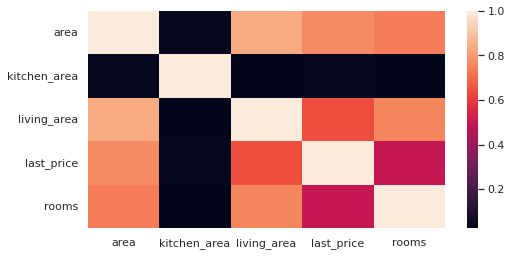

In [62]:
sns.heatmap(rent_df_cleaned[['area','kitchen_area','living_area','last_price','rooms']].corr())

<AxesSubplot:>

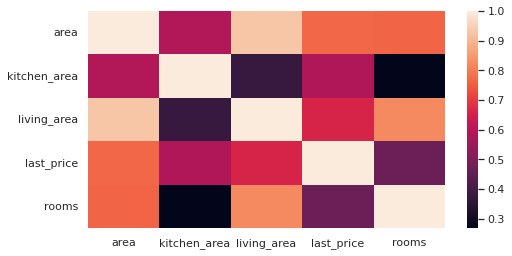

In [63]:
sns.heatmap(sell_df_cleaned[['area','kitchen_area','living_area','last_price','rooms']].corr())

In [64]:
rent_df_cleaned.first_day_exposition = pd.to_datetime(rent_df_cleaned.first_day_exposition)
rent_df_cleaned.last_day_exposition = pd.to_datetime(rent_df_cleaned.last_day_exposition)
rent_df_cleaned['expo_duration'] = (rent_df_cleaned['last_day_exposition'] - rent_df_cleaned['first_day_exposition']).dt.days

sell_df_cleaned.first_day_exposition = pd.to_datetime(sell_df_cleaned.first_day_exposition)
sell_df_cleaned.last_day_exposition = pd.to_datetime(sell_df_cleaned.last_day_exposition)
sell_df_cleaned['expo_duration'] = (sell_df_cleaned['last_day_exposition'] - sell_df_cleaned['first_day_exposition']).dt.days

In [65]:
sell_df_cleaned.expo_duration.value_counts().nlargest(20)

45     2970
60     2764
7      1675
5      1534
30     1371
6      1324
3      1269
90     1198
18     1119
4      1046
188    1043
9      1039
10      976
28      913
59      895
15      894
382     886
27      858
13      842
14      836
Name: expo_duration, dtype: int64

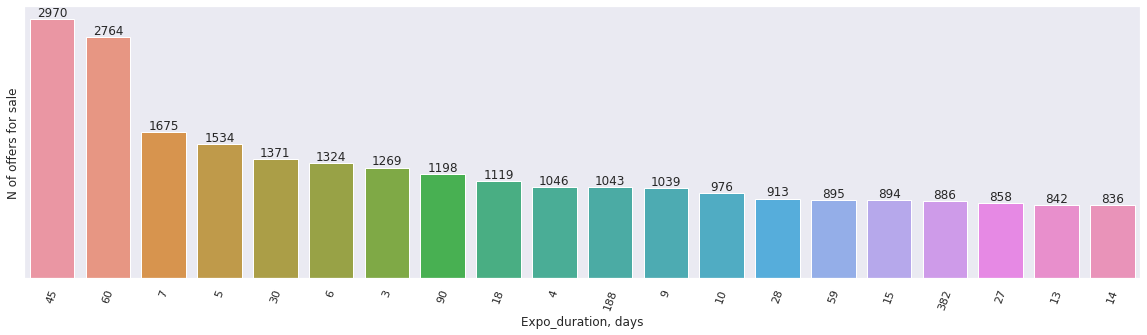

In [66]:
sells = sell_df_cleaned.expo_duration.value_counts().nlargest(20)
plt.figure(figsize=(20,5))
ax = sns.barplot(x=sells.index, y=sells, order=sells.index)
plt.yticks([])
plt.xticks(rotation=70)
ax.bar_label(ax.containers[0])
plt.ylabel('N of offers for sale')
plt.xlabel('Expo_duration, days')
plt.show()

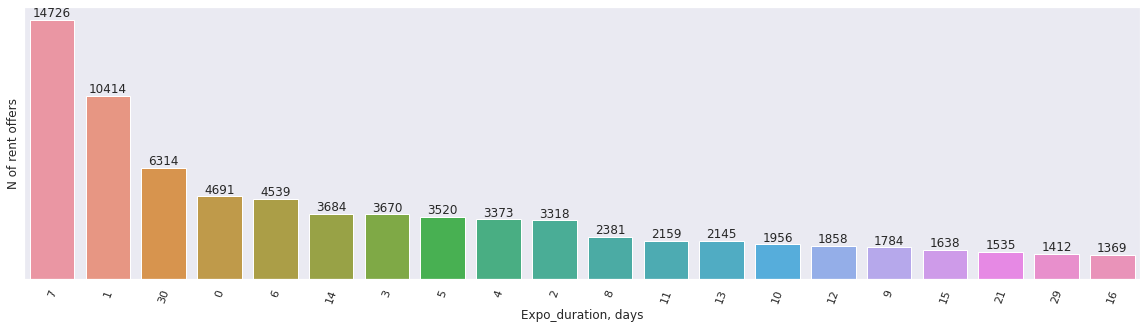

In [67]:
rents = rent_df_cleaned.expo_duration.value_counts().nlargest(20)
plt.figure(figsize=(20,5))
ax = sns.barplot(x=rents.index, y=rents, order=rents.index)
plt.yticks([])
plt.xticks(rotation=70)
ax.bar_label(ax.containers[0])
plt.ylabel('N of rent offers')
plt.xlabel('Expo_duration, days')
plt.show()

#### Let's look at the most expensive and cheapest apartments `in rent` and `for sale` without Leningrad Oblast

In [68]:
max_price_rent_cleaned = int(rent_df_cleaned.last_price.max())
min_price_rent_cleaned = int(rent_df_cleaned.last_price.min())

max_price_sell_cleaned = int(sell_df_cleaned.last_price.max())
min_price_sell_cleaned = int(sell_df_cleaned.last_price.min())

data1_rent = [[max_price_rent, min_price_rent, max_price_rent_cleaned, min_price_rent_cleaned]]
data1_sell = [[max_price_sell, min_price_sell, max_price_sell_cleaned, min_price_sell_cleaned]]

df_exp_ch_rent = pd.DataFrame(data1_rent, columns=['Max price in rent-Raw', 'Min price in rent-Raw', 'Max price in rent-Clean', 'Min price in rent-Clean'])
df_exp_ch_sell = pd.DataFrame(data1_sell, columns=['Max price for sale-Raw', 'Min price for sale-Raw', 'Max price for sale-Clean', 'Min price for sale-Clean'])

In [69]:
df_exp_ch_rent

,Max price in rent-Raw,Min price in rent-Raw,Max price in rent-Clean,Min price in rent-Clean
0,4900000,130,360000,9990


In [70]:
df_exp_ch_sell

,Max price for sale-Raw,Min price for sale-Raw,Max price for sale-Clean,Min price for sale-Clean
0,763000000,19000,103040000,1000000


#### Calculate price per square meter, get median prices for house and find outliers `for rent` and `for sale`

In [71]:
rent_df_spb['price_per_sq_m'] = rent_df_spb.last_price/rent_df_spb.area
sell_df_spb['price_per_sq_m'] = sell_df_spb.last_price/sell_df_spb.area

median_price_per_sq_m = int(rent_df_spb.price_per_sq_m.median())
mean_price_per_sq_m = int(rent_df_spb.price_per_sq_m.mean())

median_price_per_sq_m = int(sell_df_spb.price_per_sq_m.median())
mean_price_per_sq_m = int(sell_df_spb.price_per_sq_m.mean())

rent_df_cleaned['price_per_sq_m'] = rent_df_cleaned.last_price/rent_df_cleaned.area
sell_df_cleaned['price_per_sq_m'] = sell_df_cleaned.last_price/sell_df_cleaned.area

median_price_per_sq_m_rent_cleaned = int(rent_df_cleaned.price_per_sq_m.median())
mean_price_per_sq_m_rent_cleaned = int(rent_df_cleaned.price_per_sq_m.mean())

median_price_per_sq_m_sell_cleaned = int(sell_df_cleaned.price_per_sq_m.median())
mean_price_per_sq_m_sell_cleaned = int(sell_df_cleaned.price_per_sq_m.mean())

data2_rent = [[median_price_per_sq_m_rent, mean_price_per_sq_m_rent, median_price_per_sq_m_rent_cleaned, mean_price_per_sq_m_rent_cleaned]]
data2_sell = [[median_price_per_sq_m_sell, mean_price_per_sq_m_sell, median_price_per_sq_m_sell_cleaned, mean_price_per_sq_m_sell_cleaned]]

df_avg_rent = pd.DataFrame(data2_rent, columns=['Median price per sq m in rent-Raw', 'Mean price per sq m in rent-Raw', 'Median price per sq m in rent-Clean', 'Mean price per sq m in rent-Clean'])
df_avg_sell = pd.DataFrame(data2_sell, columns=['Median price per sq m for sale-Raw', 'Mean price per sq m for sale-Raw', 'Median price per sq m for sale-Clean', 'Mean price per sq m for sale-Clean'])

/tmp/ipykernel_499/1144733046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_spb['price_per_sq_m'] = rent_df_spb.last_price/rent_df_spb.area
/tmp/ipykernel_499/1144733046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_df_spb['price_per_sq_m'] = sell_df_spb.last_price/sell_df_spb.area


In [72]:
df_avg_rent

,Median price per sq m in rent-Raw,Mean price per sq m in rent-Raw,Median price per sq m in rent-Clean,Mean price per sq m in rent-Clean
0,555,610,555,600


In [73]:
df_avg_sell

,Median price per sq m for sale-Raw,Mean price per sq m for sale-Raw,Median price per sq m for sale-Clean,Mean price per sq m for sale-Clean
0,102285,113645,102229,112054


#### Find median price per sq m per house `for rent` and `for sale`

In [74]:
house_rent_df_cleaned = rent_df_cleaned.groupby('unified_address').price_per_sq_m.median().reset_index()
house_sell_df_cleaned = sell_df_cleaned.groupby('unified_address').price_per_sq_m.median().reset_index()

house_rent_df_cleaned.rename(columns = {'price_per_sq_m': 'house_price_sqm_median_rent'}, inplace = True)
house_sell_df_cleaned.rename(columns = {'price_per_sq_m': 'house_price_sqm_median_sell'}, inplace = True)

In [75]:
#house_rent_df_cleaned

#### Find the most cheapest house `for rent` and `for sale`

In [76]:
most_cheapest_house_rent = house_rent_df_cleaned[house_rent_df_cleaned.house_price_sqm_median_rent == house_rent_df_cleaned.house_price_sqm_median_rent.min()]
most_cheapest_house_rent

,unified_address,house_price_sqm_median_rent
1474,"Россия, Санкт-Петербург, Большая Зеленина улица, 12",76.923077


In [77]:
most_cheapest_house_sell = house_sell_df_cleaned[house_sell_df_cleaned.house_price_sqm_median_sell == house_sell_df_cleaned.house_price_sqm_median_sell.min()]
most_cheapest_house_sell

,unified_address,house_price_sqm_median_sell
5960,"Россия, Санкт-Петербург, Конторская улица, 16",5000.0


#### Analyze how many offers have the commission `for rent` and `for sale` 

In [78]:
rent_df_cleaned.agent_fee.value_counts(normalize=True, dropna=False)

100.000000    0.328070
50.000000     0.293406
NaN           0.209366
0.000000      0.035370
90.000000     0.034542
                ...   
14.000000     0.000006
11.000000     0.000006
17.000000     0.000006
92.000000     0.000006
64.997665     0.000006
Name: agent_fee, Length: 102, dtype: float64

We see that the most popular commission is 100% - 33% of offers. 21% of offers don't have any information about commission.

In [79]:
sell_df_cleaned.agent_fee.value_counts(normalize=True, dropna=False)

NaN           0.933603
0.000000      0.048884
100.000000    0.012877
1.000000      0.001391
1.800000      0.000706
2.000000      0.000614
2.500000      0.000279
50.000000     0.000223
4.000000      0.000198
3.000000      0.000178
2.700000      0.000168
2.400000      0.000142
1.500000      0.000117
3.500000      0.000086
10.000000     0.000086
5.000000      0.000066
2.800000      0.000051
2.200000      0.000046
4.200000      0.000046
2.450000      0.000041
1.400000      0.000030
40.000000     0.000025
20.000000     0.000025
30.000000     0.000020
15.000000     0.000015
1.050000      0.000010
6.000000      0.000010
25.000000     0.000005
48.387096     0.000005
68.259390     0.000005
30.303032     0.000005
17.000000     0.000005
1.440922      0.000005
90.909096     0.000005
27.777779     0.000005
90.000000     0.000005
0.027027      0.000005
1.250000      0.000005
74.074070     0.000005
Name: agent_fee, dtype: float64

93% of offers don't have any information about commission. 4% of offers state that there is no commission

#### Calculate how many years does it take to cover all money spent on buying apartment by renting it. Find houses in which it's the most effective to invest in buying if you plan to rent and houses in which it will be the most ineffective.

#### For price_per_sq_m

In [92]:
rent_df_cleaned_last = rent_df_cleaned.groupby('building_id').agg({'offer_id':'count', 'price_per_sq_m' : 'median'})\
.rename(columns={'offer_id' : 'rent_count_flats', 'price_per_sq_m' : 'rent_price_per_sq_m_median'}).reset_index()
rent_df_cleaned_last

,building_id,rent_count_flats,rent_price_per_sq_m_median
0,458573008430269,2,662.020906
1,1785805724177444,1,600.000000
2,3286884802341379,1,473.684211
3,3603962364551559,18,500.000000
4,3603962364551560,1,434.782609
...,...,...,...
19844,9217640295586864077,7,916.666667
19845,9217640295587698130,1,1222.222222
19846,9217640295588649554,6,671.428571
19847,9218305025595159775,2,985.110803


In [93]:
sell_df_cleaned_last = sell_df_cleaned.groupby('building_id').agg({'offer_id':'count', 'price_per_sq_m' : 'median'})\
.rename(columns={'offer_id' : 'sell_count_flats', 'price_per_sq_m' : 'sell_price_per_sq_m_median'}).reset_index()
sell_df_cleaned_last

,building_id,sell_count_flats,sell_price_per_sq_m_median
0,458573008430269,6,141157.760814
1,1785805724181110,1,93941.684665
2,3603962364551559,10,123231.911249
3,3603962364551561,8,98925.205181
4,3603962364553482,2,86649.659864
...,...,...,...
22931,9217640295586864077,4,121908.967391
22932,9217640295588649554,7,157096.424702
22933,9218305025595159777,1,210843.373494
22934,9219962699705661932,1,108333.333333


In [94]:
full = sell_df_cleaned_last.merge(rent_df_cleaned_last, on = 'building_id', how = 'outer')
full['months'] = sell_df_cleaned_last['sell_price_per_sq_m_median']\
/ rent_df_cleaned_last['rent_price_per_sq_m_median']
full = full.sort_values(by='months')
full = full.dropna()
full.months = full.months.astype(int)
full

,building_id,sell_count_flats,sell_price_per_sq_m_median,rent_count_flats,rent_price_per_sq_m_median,months
12497,5119652757321781568,1.0,13323.809524,5.0,537.037037,23
13999,5809952634093980953,1.0,18055.555556,6.0,462.962963,29
11578,4748912015298159096,16.0,94362.745098,17.0,486.486486,32
18955,7468624802346942191,2.0,73417.792793,2.0,482.558140,37
19595,7808530536558391553,1.0,37500.000000,1.0,320.000000,37
...,...,...,...,...,...,...
9681,3949170025052432380,4.0,498796.748458,3.0,1000.000000,1246
10794,4378677413263079878,6.0,548694.801775,2.0,1770.833333,1266
16118,6611791295188616970,1.0,518292.682927,3.0,2000.000000,1272
14392,5973191840232289745,2.0,764861.111111,6.0,628.685259,1459


#### For last_price

In [95]:
rent_df_cleaned_last = rent_df_cleaned.groupby('building_id').agg({'offer_id':'count', 'last_price' : 'median'})\
.rename(columns={'offer_id' : 'rent_count_flats', 'last_price' : 'rent_last_price'}).reset_index()
rent_df_cleaned_last

,building_id,rent_count_flats,rent_last_price
0,458573008430269,2,27500.0
1,1785805724177444,1,45000.0
2,3286884802341379,1,18000.0
3,3603962364551559,18,26500.0
4,3603962364551560,1,30000.0
...,...,...,...
19844,9217640295586864077,7,55000.0
19845,9217640295587698130,1,55000.0
19846,9217640295588649554,6,31500.0
19847,9218305025595159775,2,58000.0


In [96]:
sell_df_cleaned_last = sell_df_cleaned.groupby('building_id').agg({'offer_id':'count', 'last_price' : 'median'})\
.rename(columns={'offer_id' : 'sell_count_flats', 'last_price' : 'sell_last_price'}).reset_index()
sell_df_cleaned_last

,building_id,sell_count_flats,sell_last_price
0,458573008430269,6,5095000.0
1,1785805724181110,1,8699000.0
2,3603962364551559,10,5745000.0
3,3603962364551561,8,5500000.0
4,3603962364553482,2,4750000.0
...,...,...,...
22931,9217640295586864077,4,9400000.0
22932,9217640295588649554,7,8000000.0
22933,9218305025595159777,1,17500000.0
22934,9219962699705661932,1,19500000.0


In [97]:
full = sell_df_cleaned_last.merge(rent_df_cleaned_last, on = 'building_id', how = 'outer')
full['months'] = sell_df_cleaned_last['sell_last_price']\
/ rent_df_cleaned_last['rent_last_price']
full = full.sort_values(by='months')
full = full.dropna()
full.months = full.months.astype(int)
full

,building_id,sell_count_flats,sell_last_price,rent_count_flats,rent_last_price,months
9461,3819063692043546590,1.0,2325000.0,1.0,27000.0,8
11578,4748912015298159096,16.0,3749500.0,17.0,18500.0,10
13699,5675429875875671581,4.0,2740000.0,1.0,16000.0,14
15147,6257656112400819550,2.0,3085000.0,4.0,23000.0,15
4822,1842331473682593566,2.0,3100000.0,2.0,17000.0,15
...,...,...,...,...,...,...
16,15264832366839890,5.0,70000000.0,3.0,70000.0,4242
16117,6611791295188616969,2.0,82395000.0,3.0,285000.0,4342
2690,817754433912049435,1.0,70000000.0,1.0,45000.0,4666
10795,4378677413263079911,10.0,75500000.0,19.0,270000.0,4718


### Save clean datasets

In [98]:
rent_df_cleaned.to_csv('cleaned_rent.csv', index=False)

In [99]:
rent_df_cleaned.to_csv('cleaned_sell.csv', index=False)

### Self-control stops
1. Calculate median and mean prices for apartments for rent after cleaning the data in St.Petersburg without Leningrad Oblast. Which of the statistics changed more and why?
2. Calculate median and mean prices for apartments for sell before cleaning the data.
2. Find houses with the most cheapest and most expensive price per sq m in St. Petersburg without Leningrad Oblast after cleaning outliers.
3. Find the most expensive and the most cheapest apartment in St. Petersburg after cleaning outliers.
4. Calculate how many years does it take to cover all money spent on buying apartment by renting it. Find houses in which it's the most effective to invest in buying if you plan to rent and houses in which it will be the most ineffective.